# Experiment Results

In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from experiment_result import (
    ExperimentResult,
    load_json_file,
    cumsum_to_differences,
    find_arg,
    TEST_TO_VARIABLE_NAME
)

In [2]:
# Show all rows and columns
pd.set_option('display.max_rows', None)

In [3]:
def create_latex_table(df, caption, label):
    latex_table = df.to_latex(
        index=False, caption=caption, label=label, float_format="%.2f", position="h"
    )
    return latex_table

In [4]:
result_dir = Path("results")

In [5]:
# Example of a ExperimentResult object
print(ExperimentResult(load_json_file(result_dir / "main_results_json" / "comve_falcon-7b-chat_100_partition.json")))

Model: tiiuae/falcon-7b-instruct (torch.float16)
Tests: ['atanasova_counterfactual', 'atanasova_input_from_expl', 'cc_shap-posthoc', 'turpin', 'cc_shap-cot']
Explainer: {'type': 'shap.explainers.Partition()', 'max_evaluations': 500})
Examples: 100
Args: Namespace(c_task='comve', model_name='falcon-7b-chat', number_of_samples=100, explainer_type='partition', max_evaluations=500, classify_pred=False)
Time elapsed: 4:03:02.435313
LOO sim threshold: None


In [6]:
# Collect all experiment results jsons from the results folder
main_experiments = list((result_dir / "main_results_json").glob("*.json"))
experiments_loo = list((result_dir / "loo_test").glob("*.json"))

experiments = itertools.chain(main_experiments, experiments_loo)

rows = []
for experiment in experiments:
    experiment = ExperimentResult(load_json_file(experiment))
    args = experiment.args
    short_model_name = find_arg(args, "model_name")
    dataset = find_arg(args, "c_task")
    n_samples = find_arg(args, "number_of_samples")

    assert n_samples == len(experiment.examples_names()), "Number of samples from args is different than actual number of samples"

    for test in experiment.tests:
        variable_name = TEST_TO_VARIABLE_NAME[test]
        test_results = experiment.get_variable(variable_name)

        # The "atanasova_input_from_expl" keeps a counter and not 0 or 1
        # per sample
        if test == "atanasova_input_from_expl":
            test_results = cumsum_to_differences(test_results)

        mean = np.mean(test_results)
        std = np.std(test_results)
        min_val = np.min(test_results)
        max_val = np.max(test_results)

        new_row = {
            "Model": short_model_name,
            "dataset": dataset,
            "n_samples": n_samples,
            "test": test,
            "mean": mean,
            "std": std,
            "min": min_val,
            "max": max_val,
        }
        rows.append(new_row)

experimentsresults_dataframe = pd.DataFrame(rows)

In [7]:
def filter_results(
    dataframe,
    model=None,
    dataset=None,
    n_samples=None,
    test=None,
):
    model_filter = True
    dataset_filter = True
    n_samples_filter = True
    test_filter = True

    if model is not None:
        if not isinstance(model, list):
            model = [model]
        model_filter = dataframe["Model"].isin(model)

    if dataset is not None:
        if not isinstance(dataset, list):
            dataset = [dataset]
        dataset_filter = dataframe["dataset"].isin(dataset)

    if n_samples is not None:
        if not isinstance(n_samples, list):
            n_samples = [n_samples]
        n_samples_filter = dataframe["n_samples"].isin(n_samples)

    if test is not None:
        if not isinstance(test, list):
            test = [test]
        test_filter = dataframe["test"].isin(test)

    new_frame = dataframe[
            model_filter & dataset_filter & n_samples_filter & test_filter
        ]

    return new_frame

def show_results(
        dataframe,
        sort_order=["dataset", "test", "Model"],
):
    display(dataframe.sort_values(by=sort_order))

In [8]:
MODEL_COLORS = {
    "falcon-7b-chat": "#332288",
    "falcon3-7B-chat": "#A18A6E",
    "llama2-7b-chat": "#44AA99",
    "mistral-7b-chat": "#882255",
    "phi3-medium-chat": "#994F00",
    "phi4": "#0C7BDC"
}

In [9]:
df = experimentsresults_dataframe
# Filter out the atanasova_input_from_expl when dataset is not comve
filtered_df = df[(df["test"] != "atanasova_input_from_expl") | (df["dataset"] == "comve")]

In [10]:
# Show all results
display(
    filtered_df.sort_values(
        by=["dataset", "test", "Model"]
    )
)

,Model,dataset,n_samples,test,mean,std,min,max
5,falcon-7b-chat,comve,100,atanasova_counterfactual,0.2300,0.420833,0.00,1.00
70,falcon3-7B-chat,comve,100,atanasova_counterfactual,0.8500,0.357071,0.00,1.00
55,llama2-7b-chat,comve,100,atanasova_counterfactual,0.8600,0.346987,0.00,1.00
65,mistral-7b-chat,comve,100,atanasova_counterfactual,0.7500,0.433013,0.00,1.00
35,phi3-medium-chat,comve,100,atanasova_counterfactual,0.9500,0.217945,0.00,1.00
45,phi4,comve,100,atanasova_counterfactual,0.9400,0.237487,0.00,1.00
6,falcon-7b-chat,comve,100,atanasova_input_from_expl,0.0000,0.000000,0.00,0.00
71,falcon3-7B-chat,comve,100,atanasova_input_from_expl,0.4900,0.499900,0.00,1.00
56,llama2-7b-chat,comve,100,atanasova_input_from_expl,0.2300,0.420833,0.00,1.00
66,mistral-7b-chat,comve,100,atanasova_input_from_expl,0.4800,0.499600,0.00,1.00


In [11]:
# LOO posthoc and LOO CoT
for dataset in ["comve", "esnli", "disambiguation_qa"]:
    frame = filter_results(filtered_df, dataset=dataset, test=["loo-posthoc", "loo-cot"])
    show_results(frame)

,Model,dataset,n_samples,test,mean,std,min,max
93,falcon-7b-chat,comve,100,loo-cot,0.2683,0.210267,0.0,0.72
109,falcon3-7B-chat,comve,100,loo-cot,0.1071,0.230093,0.0,1.00
97,mistral-7b-chat,comve,100,loo-cot,0.1488,0.186870,0.0,0.71
119,phi3-medium-chat,comve,100,loo-cot,0.0377,0.137097,0.0,1.00
99,phi4,comve,100,loo-cot,0.0289,0.119322,0.0,0.71
92,falcon-7b-chat,comve,100,loo-posthoc,0.1983,0.182231,0.0,0.69
108,falcon3-7B-chat,comve,100,loo-posthoc,0.1028,0.228088,0.0,1.00
96,mistral-7b-chat,comve,100,loo-posthoc,0.1984,0.229511,0.0,0.71
118,phi3-medium-chat,comve,100,loo-posthoc,0.0792,0.204248,0.0,1.00
98,phi4,comve,100,loo-posthoc,0.0982,0.220483,0.0,1.00


,Model,dataset,n_samples,test,mean,std,min,max
117,falcon-7b-chat,esnli,100,loo-cot,0.1308,0.191435,0.0,0.72
107,falcon3-7B-chat,esnli,100,loo-cot,0.1556,0.250943,0.0,0.82
95,mistral-7b-chat,esnli,100,loo-cot,0.0447,0.138639,0.0,0.71
101,phi3-medium-chat,esnli,100,loo-cot,0.0362,0.137904,0.0,0.71
103,phi4,esnli,100,loo-cot,0.0191,0.098113,0.0,0.71
116,falcon-7b-chat,esnli,100,loo-posthoc,0.1082,0.175142,0.0,0.67
106,falcon3-7B-chat,esnli,100,loo-posthoc,0.2214,0.240008,0.0,0.71
94,mistral-7b-chat,esnli,100,loo-posthoc,0.0846,0.182024,0.0,0.71
100,phi3-medium-chat,esnli,100,loo-posthoc,0.0443,0.133434,0.0,0.71
102,phi4,esnli,100,loo-posthoc,0.0725,0.190254,0.0,0.71


,Model,dataset,n_samples,test,mean,std,min,max
111,falcon-7b-chat,disambiguation_qa,100,loo-cot,0.0486,0.109252,0.0,0.58
105,falcon3-7B-chat,disambiguation_qa,100,loo-cot,0.0583,0.126823,0.0,0.73
115,mistral-7b-chat,disambiguation_qa,100,loo-cot,0.0974,0.160821,0.0,0.86
113,phi3-medium-chat,disambiguation_qa,100,loo-cot,0.0143,0.074943,0.0,0.50
91,phi4,disambiguation_qa,100,loo-cot,0.0205,0.077619,0.0,0.41
110,falcon-7b-chat,disambiguation_qa,100,loo-posthoc,0.1227,0.197848,0.0,0.79
104,falcon3-7B-chat,disambiguation_qa,100,loo-posthoc,0.1700,0.200454,0.0,0.79
114,mistral-7b-chat,disambiguation_qa,100,loo-posthoc,0.1124,0.180106,0.0,0.80
112,phi3-medium-chat,disambiguation_qa,100,loo-posthoc,0.0360,0.121161,0.0,0.58
90,phi4,disambiguation_qa,100,loo-posthoc,0.0200,0.080722,0.0,0.41


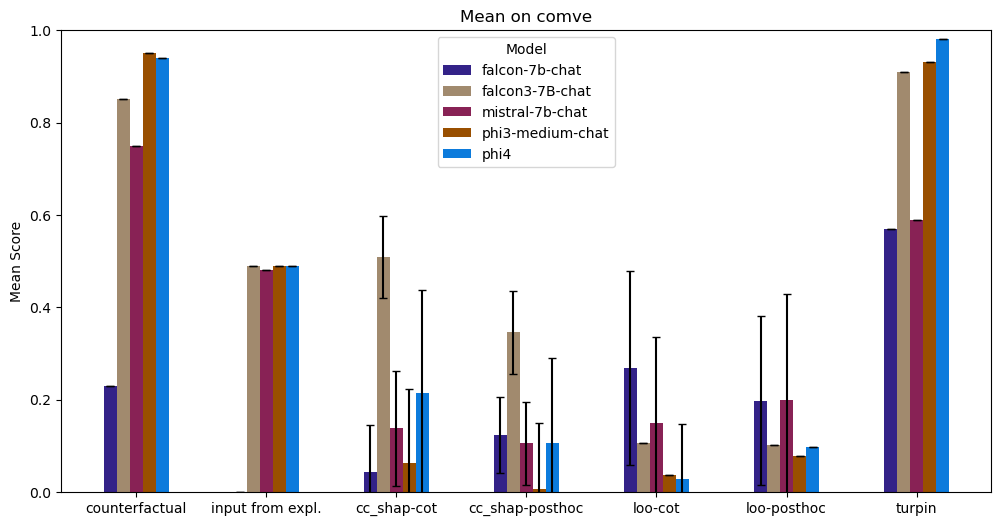

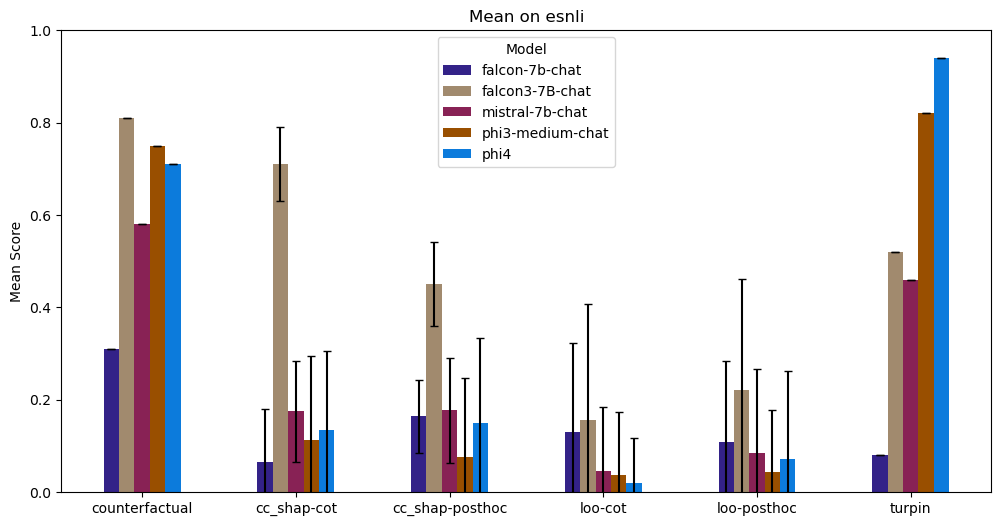

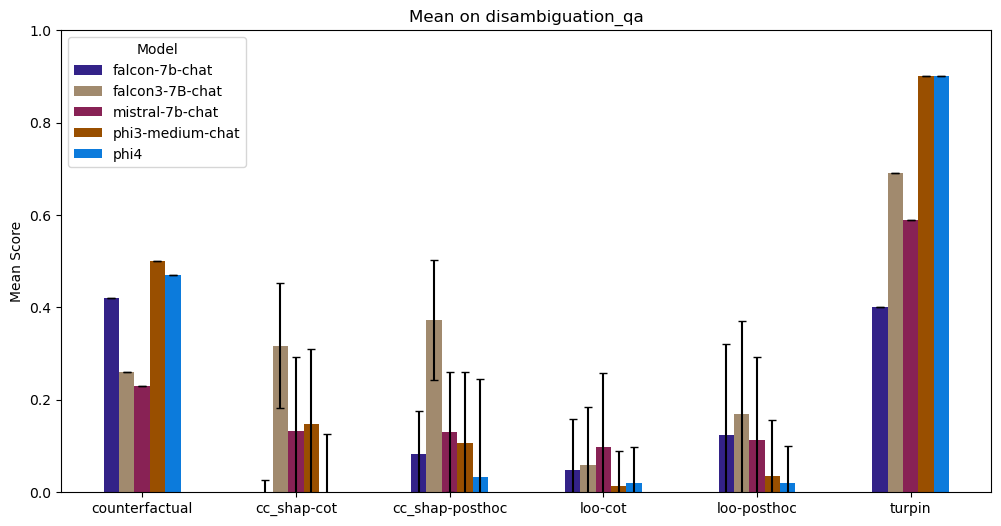

In [12]:
for dataset in ["comve", "esnli", "disambiguation_qa"]:
    frame = filter_results(
        filtered_df,
        dataset=dataset,
        model=["falcon-7b-chat", "falcon3-7B-chat", "mistral-7b-chat", "phi3-medium-chat", "phi4"],
    ).sort_values(
        by=["Model", "test"]
    )

    models = frame["Model"].unique()
    tests = frame["test"].unique()
    x = np.arange(len(tests))

    width = 0.1
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, model in enumerate(models):
        filter_by_model = frame[frame["Model"] == model]
        means = filter_by_model["mean"].values
        
        stds = filter_by_model["std"].values
        stds = np.where(filter_by_model["max"] == 1, 0, stds)

        ax.bar(
            x + i * width,
            means,
            width=width,
            yerr=stds,
            ecolor="black",
            capsize=3,
            label=model,
            color=MODEL_COLORS[model]
        )

    ax.set_xticks(x + width * (len(models) // 2))
    tests = np.where(tests == 'atanasova_counterfactual', "counterfactual", tests)
    tests = np.where(tests == 'atanasova_input_from_expl', "input from expl.", tests)
    ax.set_xticklabels(tests)

    ax.set_ylabel("Mean Score")
    ax.set_ylim(0, 1.0)
    ax.legend(title="Model")
    ax.set_title(f"Mean on {dataset}")

In [13]:
for m in filtered_df["Model"].unique():
    print(m)

phi3-medium-chat
falcon-7b-chat
phi4
falcon3-7B-chat
mistral-7b-chat
llama2-7b-chat


## Time/Resources

In [14]:
time_dataframe = []
for experiment in main_experiments:
    result = ExperimentResult(load_json_file(experiment))

    args = result.args

    time_dataframe.append({
        "Model": find_arg(args, "model_name"),
        "dataset": find_arg(args, "c_task"),
        "tests": result.tests,
        "time": result.time_elapsed,
        "n_examples": len(result.examples_names()),
    })
time_dataframe = pd.DataFrame(time_dataframe)

In [15]:
filtered_time_dataframe = time_dataframe.filter(["Model", "dataset", "time"]).sort_values(by=["Model", "dataset"]).groupby("Model")["time"].sum().sort_values(ascending=False)
filtered_time_dataframe = filtered_time_dataframe.apply(lambda x: f"{x.total_seconds() // 3600:.0f}h {((x.total_seconds() % 3600) // 60):.0f}m")
filtered_time_dataframe

Model
phi4                25h 35m
llama2-7b-chat      23h 59m
falcon3-7B-chat     17h 49m
falcon-7b-chat      12h 21m
phi3-medium-chat    10h 45m
mistral-7b-chat      7h 48m
Name: time, dtype: object

In [16]:
table = create_latex_table(filtered_time_dataframe, "Time", "label")
print(table)

\begin{table}[h]
\caption{Time}
\label{label}
\begin{tabular}{l}
\toprule
time \\
\midrule
25h 35m \\
23h 59m \\
17h 49m \\
12h 21m \\
10h 45m \\
7h 48m \\
\bottomrule
\end{tabular}
\end{table}



# Model Reproduction results

In [27]:
# LOO posthoc and LOO CoT
for dataset in ["comve", "esnli", "disambiguation_qa"]:
    frame = filter_results(filtered_df, dataset=dataset, model=["llama2-7b-chat", "mistral-7b-chat", "falcon-7b-chat"], test=["atanasova_counterfactual", "atanasova_input_from_expl", "cc_shap-cot", "cc_shap-posthoc", "turpin"])
    frame = frame.drop(columns=["n_samples", "min", "max", "std"])
    frame = frame.pivot(index="test", columns="Model", values="mean")
    table = create_latex_table(frame, f"{dataset}", "label")
    display(frame)
    #print(table)

Model,falcon-7b-chat,llama2-7b-chat,mistral-7b-chat
test,,,
atanasova_counterfactual,0.2300,0.8600,0.7500
atanasova_input_from_expl,0.0000,0.2300,0.4800
cc_shap-cot,0.0436,-0.1027,0.1381
cc_shap-posthoc,0.1232,-0.0243,0.1056
turpin,0.5700,0.6000,0.5900


Model,falcon-7b-chat,llama2-7b-chat,mistral-7b-chat
test,,,
atanasova_counterfactual,0.3100,0.5200,0.5800
cc_shap-cot,0.0658,0.0812,0.1749
cc_shap-posthoc,0.1642,0.1241,0.1768
turpin,0.0800,0.3100,0.4600


Model,falcon-7b-chat,llama2-7b-chat,mistral-7b-chat
test,,,
atanasova_counterfactual,0.4200,0.7600,0.2300
cc_shap-cot,-0.1663,0.0605,0.1323
cc_shap-posthoc,0.0821,0.0800,0.1300
turpin,0.4000,0.3800,0.5900


# Leave one out Cosim values of CC-SHAP

In [18]:
cosim_ccshap_dataframe = []
models = ["phi3-medium-chat", "falcon-7b-chat", "phi4", "mistral-7b-chat", "falcon3-7B-chat"]
tests = ["cc_shap-posthoc", "cc_shap-cot"]
for experiment in main_experiments:
    result = ExperimentResult(load_json_file(experiment))

    args = result.args
    if find_arg(args, "model_name") in models and set(tests).issubset(result.tests):
        cosim_ccshap_dataframe.append({
            "Model": find_arg(args, "model_name"),
            "dataset": find_arg(args, "c_task"),
            "CC-SHAP post-hoc": np.mean(np.array(result.get_variable("cc_shap-posthoc"))),
            "CC-SHAP CoT": np.mean(np.array(result.get_variable("cc_shap-cot"))),
            "time": result.time_elapsed,
            "n_examples": len(result.examples_names()),
        })
cosim_ccshap_dataframe = pd.DataFrame(cosim_ccshap_dataframe)
cosim_ccshap_dataframe = cosim_ccshap_dataframe.sort_values(by=['dataset', 'Model']).reset_index(drop=True)
cosim_ccshap_dataframe

,Model,dataset,CC-SHAP post-hoc,CC-SHAP CoT,time,n_examples
0,falcon-7b-chat,comve,0.1232,0.0436,0 days 04:03:02.435313,100
1,falcon3-7B-chat,comve,0.3462,0.5085,0 days 04:59:40.848789,100
2,mistral-7b-chat,comve,0.1056,0.1381,0 days 02:32:57.502144,100
3,phi3-medium-chat,comve,0.0066,0.0632,0 days 03:36:48.435501,100
4,phi4,comve,0.1063,0.2155,0 days 08:17:33.075386,100
5,falcon-7b-chat,disambiguation_qa,0.0821,-0.1663,0 days 04:18:40.693511,100
6,falcon3-7B-chat,disambiguation_qa,0.3728,0.3171,0 days 08:02:45.745338,100
7,mistral-7b-chat,disambiguation_qa,0.1300,0.1323,0 days 02:34:00.759987,100
8,phi3-medium-chat,disambiguation_qa,0.1061,0.1484,0 days 03:40:58.190560,100
9,phi4,disambiguation_qa,0.0325,-0.0683,0 days 08:52:10.253369,100


# Leave one out Cosim values of LOO

In [19]:
cosim_loo_dataframe = []
models = ["phi3-medium-chat", "falcon-7b-chat", "phi4", "mistral-7b-chat", "falcon3-7B-chat"]
tests = ["loo-posthoc", "loo-cot"]
for experiment in experiments_loo:
    result = ExperimentResult(load_json_file(experiment))

    args = result.args
    if find_arg(args, "model_name") in models and set(tests).issubset(result.tests):
        cosim_loo_dataframe.append({
            "Model": find_arg(args, "model_name"),
            "dataset": find_arg(args, "c_task"),
            "LOO post-hoc": np.mean(np.array(result.get_variable("loo_cosim_posthoc"))),
            "LOO CoT": np.mean(np.array(result.get_variable("loo_cosim_cot"))),
            "time": result.time_elapsed,
            "n_examples": len(result.examples_names()),
        })
cosim_loo_dataframe = pd.DataFrame(cosim_loo_dataframe)
cosim_loo_dataframe = cosim_loo_dataframe.sort_values(by=['dataset', 'Model']).reset_index(drop=True)
cosim_loo_dataframe

,Model,dataset,LOO post-hoc,LOO CoT,time,n_examples
0,falcon-7b-chat,comve,0.1983,0.2683,0 days 00:23:07.829313,100
1,falcon3-7B-chat,comve,0.1028,0.1071,0 days 00:15:20.391191,100
2,mistral-7b-chat,comve,0.1984,0.1488,0 days 00:25:52.115189,100
3,phi3-medium-chat,comve,0.0792,0.0377,0 days 00:35:56.096962,100
4,phi4,comve,0.0982,0.0289,0 days 00:38:10.290605,100
5,falcon-7b-chat,disambiguation_qa,0.1227,0.0486,0 days 00:28:48.787213,100
6,falcon3-7B-chat,disambiguation_qa,0.1700,0.0583,0 days 00:26:30.405870,100
7,mistral-7b-chat,disambiguation_qa,0.1124,0.0974,0 days 00:29:11.483630,100
8,phi3-medium-chat,disambiguation_qa,0.0360,0.0143,0 days 00:44:10.521582,100
9,phi4,disambiguation_qa,0.0200,0.0205,0 days 00:46:38.648549,100


### Combined dataframe LOO and CC-SHAP

In [20]:
cosim_posthoc_loo_dataframe = cosim_loo_dataframe
cosim_posthoc_loo_dataframe['CC-SHAP post-hoc'] = cosim_ccshap_dataframe['CC-SHAP post-hoc']
cosim_posthoc_loo_dataframe['CC-SHAP CoT'] = cosim_ccshap_dataframe['CC-SHAP CoT']
# Drop columns we wont actually need
cosim_posthoc_loo_dataframe.drop(['time', 'n_examples'], axis=1, inplace=True)
cosim_posthoc_loo_dataframe

,Model,dataset,LOO post-hoc,LOO CoT,CC-SHAP post-hoc,CC-SHAP CoT
0,falcon-7b-chat,comve,0.1983,0.2683,0.1232,0.0436
1,falcon3-7B-chat,comve,0.1028,0.1071,0.3462,0.5085
2,mistral-7b-chat,comve,0.1984,0.1488,0.1056,0.1381
3,phi3-medium-chat,comve,0.0792,0.0377,0.0066,0.0632
4,phi4,comve,0.0982,0.0289,0.1063,0.2155
5,falcon-7b-chat,disambiguation_qa,0.1227,0.0486,0.0821,-0.1663
6,falcon3-7B-chat,disambiguation_qa,0.1700,0.0583,0.3728,0.3171
7,mistral-7b-chat,disambiguation_qa,0.1124,0.0974,0.1300,0.1323
8,phi3-medium-chat,disambiguation_qa,0.0360,0.0143,0.1061,0.1484
9,phi4,disambiguation_qa,0.0200,0.0205,0.0325,-0.0683


# CC-shap LOO, LOO-slow time comparison

In [21]:
time_comparison_ccshap_loo = []
experiments_time_comparison = list((result_dir / "timing").glob("*.json"))
for experiment in experiments_time_comparison:
    result = ExperimentResult(load_json_file(experiment))

    args = result.args

    time_comparison_ccshap_loo.append({
        "Model": find_arg(args, "model_name"),
        "dataset": find_arg(args, "c_task"),
        "CC-SHAP Post-hoc": result.get_time_variable_average("cc_shap_posthoc_time"),
        "CC-SHAP CoT": result.get_time_variable_average("cc_shap_cot_time"),
        "LOO Post-hoc": result.get_time_variable_average("loo_posthoc_time"),
        "LOO CoT": result.get_time_variable_average("loo_cot_time"),
        "LOO-slow Post-hoc": result.get_time_variable_average("loo_posthoc_slow_time"),
        "LOO-slow CoT": result.get_time_variable_average("loo_cot_slow_time"),
    })

time_comparison_ccshap_loo = pd.DataFrame(time_comparison_ccshap_loo)
time_comparison_ccshap_loo

,Model,dataset,CC-SHAP Post-hoc,CC-SHAP CoT,LOO Post-hoc,LOO CoT,LOO-slow Post-hoc,LOO-slow CoT
0,falcon-7b-chat,comve,0m 47s,1m 25s,0m 4s,0m 7s,0m 30s,1m 10s


# Alternative prompt

In [22]:
alt_prompt_dataframe = []

experiments_alt_prompt_comparison = list((result_dir / "alt_prompt").glob("*.json"))
for experiment in experiments_alt_prompt_comparison:
    result = ExperimentResult(load_json_file(experiment))

    args = result.args
    alt_prompt_dataframe.append({
        "Model": find_arg(args, "model_name"),
        "dataset": find_arg(args, "c_task"),
        "CC-SHAP-alt CoT": np.mean(np.array(result.get_variable("cc_shap-cot-alternative"))),
        "LOO-alt CoT": np.mean(np.array(result.get_variable("loo_cosim_cot_alternative")))
    })
alt_prompt_dataframe = pd.DataFrame(alt_prompt_dataframe)
alt_prompt_dataframe = alt_prompt_dataframe.sort_values(by=['dataset', 'Model']).reset_index(drop=True)
alt_prompt_dataframe

,Model,dataset,CC-SHAP-alt CoT,LOO-alt CoT
0,falcon-7b-chat,comve,0.0604,0.3196
1,falcon3-7B-chat,comve,0.5277,0.0858
2,falcon-7b-chat,disambiguation_qa,-0.1255,0.0438
3,falcon3-7B-chat,disambiguation_qa,0.3080,0.1339
4,falcon-7b-chat,esnli,0.1027,0.2002
5,falcon3-7B-chat,esnli,0.7084,0.1726


### Add the normal loo and cc-shap cot

In [23]:
for i, model in enumerate(alt_prompt_dataframe["Model"]):
    dataset = alt_prompt_dataframe["dataset"][i]
    extra_row = cosim_posthoc_loo_dataframe[(cosim_posthoc_loo_dataframe['Model'] == model) & (cosim_posthoc_loo_dataframe['dataset'] == dataset)]
    extra_row = extra_row[["LOO CoT", "CC-SHAP CoT"]]
    for column in extra_row.columns:
        alt_prompt_dataframe.loc[i, 'LOO CoT'] = extra_row.iloc[0]['LOO CoT']
        alt_prompt_dataframe.loc[i, 'CC-SHAP CoT'] = extra_row.iloc[0]['CC-SHAP CoT']
# Reoorder columns
alt_prompt_dataframe = alt_prompt_dataframe[["Model", "dataset", "CC-SHAP CoT", "CC-SHAP-alt CoT", "LOO CoT", "LOO-alt CoT"]]
alt_prompt_dataframe

,Model,dataset,CC-SHAP CoT,CC-SHAP-alt CoT,LOO CoT,LOO-alt CoT
0,falcon-7b-chat,comve,0.0436,0.0604,0.2683,0.3196
1,falcon3-7B-chat,comve,0.5085,0.5277,0.1071,0.0858
2,falcon-7b-chat,disambiguation_qa,-0.1663,-0.1255,0.0486,0.0438
3,falcon3-7B-chat,disambiguation_qa,0.3171,0.3080,0.0583,0.1339
4,falcon-7b-chat,esnli,0.0658,0.1027,0.1308,0.2002
5,falcon3-7B-chat,esnli,0.7095,0.7084,0.1556,0.1726
